**Clustering homework**

In [ ]:
!pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184505 sha256=3ca21ff82a2553b38218da7466c228f1af535c53a37743dd320219a62bc40f90
  Stored in directory: /root/.cache/pip/wheels/32/b8/b2/c4c2b95765e615fe139b0b17b5ea7c0e1b6519b0a9ec8fb34d
Successfully built python-docx


In [ ]:
import docx
file_name = 'Clustering_Homework.docx'
doc = docx.Document(file_name)

In [ ]:
fullText = []
for para in doc.paragraphs:
    fullText.append(para.text)

for line in fullText:
  print(line)

Dataset: quake can be imported via library bds_courseware:

pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)

The dataset is also available via link:


It contains information about earthquakes: coordinates, depth and strength. Your task is to cluster the data:
Evaluation criteria (100% in total):
Exploratory analysis (there are some specific characteristics of features, which may change the result of the analysis)  (10%)
Build K-Means with 15 clusters (10%)
Determine optimal number of clusters for K-Means (10%)
Create visualization for the obtained clusters (10%)
Try other clustering algorithms; tune their hyperparameters to achieve better results. You should use at least two different algorith

In [ ]:
import numpy as np
import pandas as pd

import itertools

from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly

from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples

%matplotlib inline

# EDA + DP

In [ ]:
df = pd.read_csv('quake.csv')

In [ ]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


So we have a dataset about earth quakes. With the latitude ang longitude data, we can get where it was. Later it will help in visualization.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [ ]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


In [ ]:
df.isnull().sum()

Focal depth    0
Latitude       0
Longitude      0
Richter        0
dtype: int64

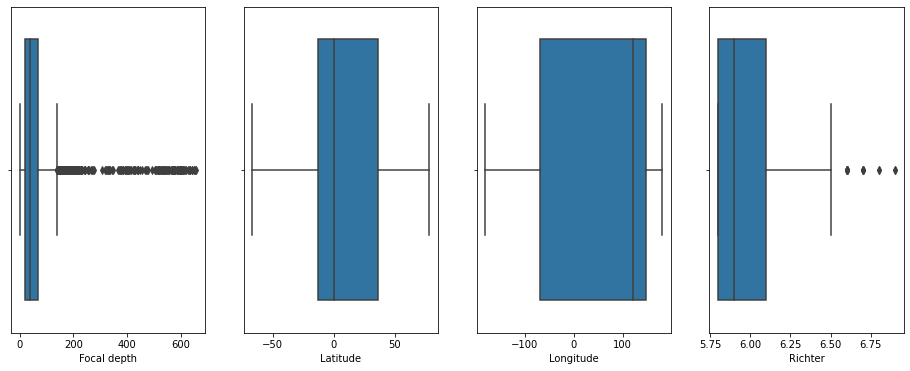

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (16, 6))

sns.boxplot(x=df["Focal depth"], ax=axes[0])
sns.boxplot(x=df["Latitude"], ax=axes[1])
sns.boxplot(x=df["Longitude"], ax=axes[2])
sns.boxplot(x=df["Richter"], ax=axes[3])

plt.show()

In `Focal depth` feature there can be some outliers. Lets dive deeper.

In [ ]:
df['Focal depth'].describe()

count    2178.000000
mean       74.359963
std       116.467797
min         0.000000
25%        21.000000
50%        39.000000
75%        68.000000
max       656.000000
Name: Focal depth, dtype: float64

In [ ]:
print(df['Focal depth'].quantile(.95))
df['Focal depth'][df['Focal depth'] > df['Focal depth'].quantile(.95)].count()

349.1500000000019


109

There is 109 cases when the Focal depth was deeper than 349.15 km.

In [ ]:
print(df['Focal depth'].quantile(.99))
df['Focal depth'][df['Focal depth'] > df['Focal depth'].quantile(.99)].count()

598.23


22

And there is 22 cases when the quake was deeper than 598.23. That is possible, I did some research, and the maximum depth of an earth quake can be about 700km.

The maximum in our dataset is 656, so that's seems to be not an error.

## Visualization

In [ ]:
!pip install mpl_toolkits
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.5 MB/s eta 0:00:00


In [ ]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

In [ ]:
longitudes = df['Longitude'].tolist()
latitudes = df['Latitude'].tolist()

x, y = m(longitudes, latitudes)

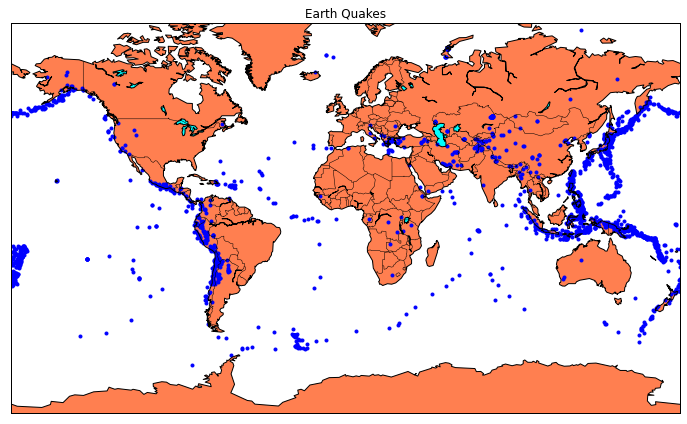

In [ ]:
fig = plt.figure(figsize = (12, 10))
m.plot(x, y, 'o', markersize = 3, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color = 'coral', lake_color = 'aqua')
m.drawmapboundary()
m.drawcountries()
plt.title('Earth Quakes')
plt.show()

We can clearly see where the quakes were.

<AxesSubplot:>

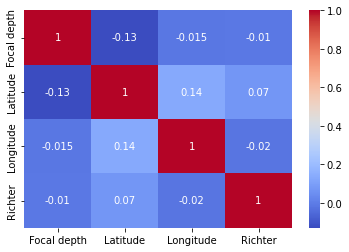

In [ ]:
corr = df[['Focal depth', 'Latitude', 'Longitude', 'Richter']].corr()
sns.heatmap(corr, cmap = 'coolwarm', annot = True)

There is not so much correlation between the features.

## Scaling

I use Standard Scaler, since if I use MinMax, there will be some extreme values for example in the focal depth. While 70-100km values are more often than 500+, there will be even higher depths, which aren't errors, as I mentoined above.

In [ ]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df)

In [ ]:
df_scaled

array([[-0.35520086, -1.97199797, -0.22393957,  3.81670737],
       [-0.32943675,  1.23018213,  0.80788009, -0.9355697 ],
       [-0.14908799,  1.10967878,  0.73930527, -0.9355697 ],
       ...,
       [ 3.88728899,  0.65189703,  0.7117912 , -0.9355697 ],
       [-0.20061621,  0.9321983 ,  0.72415991,  0.12049187],
       [-0.28649657,  0.52582694,  0.56639575, -0.9355697 ]])

Now I don't want to use dimension reduction, since our data has not so much feature, only four.

# K-Means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters = 15, random_state = 42)

kmeans.fit(df_scaled)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
centroids

array([[ 1.0480322 ,  0.11095665,  0.6123099 , -0.31153331],
       [-0.35628894,  1.06119325,  0.44413067,  0.52428012],
       [-0.09220143, -1.29362925, -1.40686332,  0.48153856],
       [ 3.91793266, -0.96641417, -1.66507404, -0.27553122],
       [-0.25916421,  0.02814696, -1.08077912, -0.40294734],
       [-0.13119625, -0.52101591,  0.72964099,  1.68258294],
       [ 3.70061848,  0.11503495,  0.71952281,  0.05448803],
       [-0.18054684, -1.25849331, -1.35820864, -0.72661634],
       [-0.40167729,  1.49886289, -1.7075675 , -0.1679283 ],
       [-0.16206339, -0.45077307,  0.71039053,  0.33572181],
       [-0.21272493, -0.4007839 ,  0.70283279, -0.7103433 ],
       [-0.36783032,  1.08995445,  0.52740388, -0.70088935],
       [-0.40639877, -1.66385044,  0.63270039, -0.54970105],
       [-0.22614176,  1.11546382,  0.47581692,  2.46729536],
       [-0.26921447, -0.18814976, -1.41282222,  1.97837797]])

In [ ]:
labels

array([ 5, 11, 11, ...,  6,  1, 11], dtype=int32)

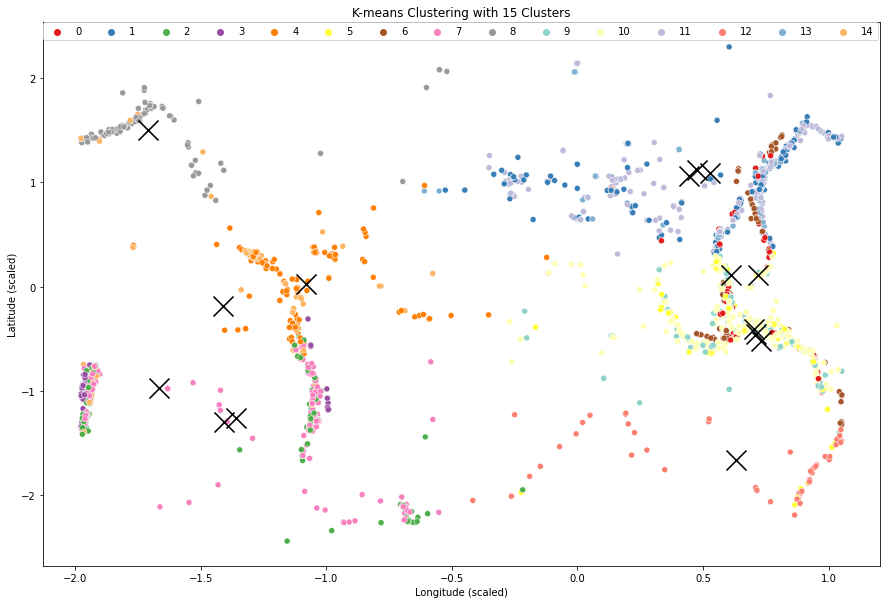

In [ ]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#8dd3c7',
          '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462']

plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_scaled[:, 2], y=df_scaled[:, 1], hue=labels, palette=colors)
sns.scatterplot(x=centroids[:, 2], y=centroids[:, 1], color='black', marker='x', s=400)
plt.xlabel('Longitude (scaled)')
plt.ylabel('Latitude (scaled)')
plt.title('K-means Clustering with 15 Clusters')
plt.legend(loc = 'upper left', borderaxespad = 0., ncol = 15)
plt.show()

In this plot we can se can see that around the black X marks represent the centroids of each 15 clusters, and the points around the crosses are the data points that belong to that cluster.

Also, the colors help us to identify the different clusters.

## Elbow method

Text(0.5, 1.0, 'Elbow Method for Optimal Number of Clusters')

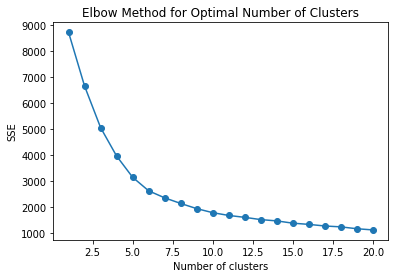

In [ ]:
sse = []
for k in range(1, 21):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(df_scaled)
  sse.append(kmeans.inertia_)

plt.plot(range(1, 21), sse, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')

## Dendrogram

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5],
  [65.0, 65.0, 75.0, 75.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [70.0, 70.0, 92.5, 92.5],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [120.0, 120.0, 150.0, 150.0],
  [81.25, 81.25, 135.0, 135.0],
  [27.5, 27.5, 108.125, 108.125],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [175.0, 175.0, 192.5, 192.5],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [230.0, 230.0, 263.75, 263.75],
  [183.75, 183.75, 246.875, 246.875],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [325.0, 325.0, 335.0, 335.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0

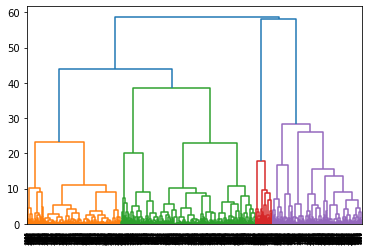

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(df_scaled, method = 'ward')
dendrogram(Z)

I would say the elbow point is around 6 cluster.

Let's plot it again with 6 cluster.

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 42)

kmeans.fit(df_scaled)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

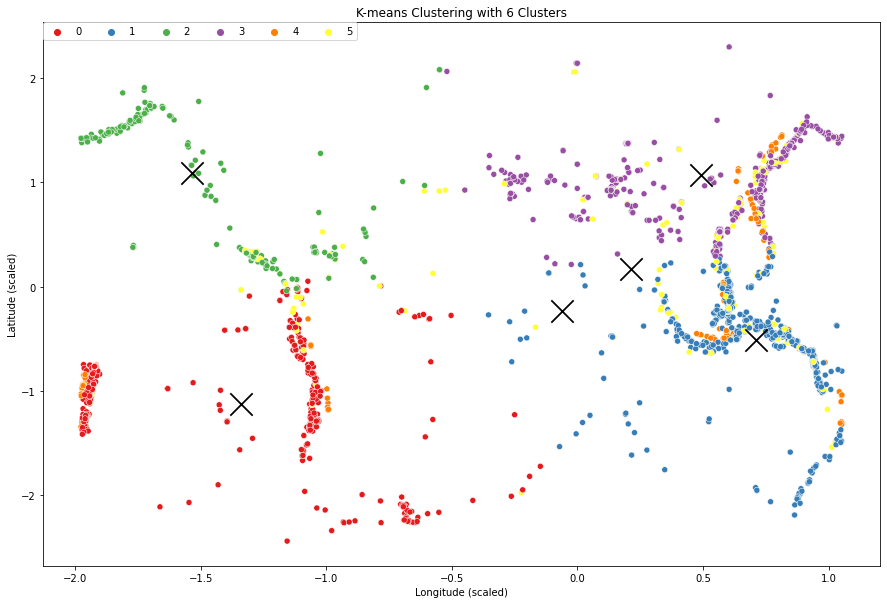

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_scaled[:, 2], y=df_scaled[:, 1], hue=labels, palette=colors)
sns.scatterplot(x=centroids[:, 2], y=centroids[:, 1], color='black', marker='x', s=500)
plt.xlabel('Longitude (scaled)')
plt.ylabel('Latitude (scaled)')
plt.title('K-means Clustering with 6 Clusters')
plt.legend(loc = 'upper left', borderaxespad = 0., ncol = 6)
plt.show()

# Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
n_clusters = 6
linkage = 'ward'
agg_clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage)

In [ ]:
cluster_labels = agg_clustering.fit_predict(df_scaled)

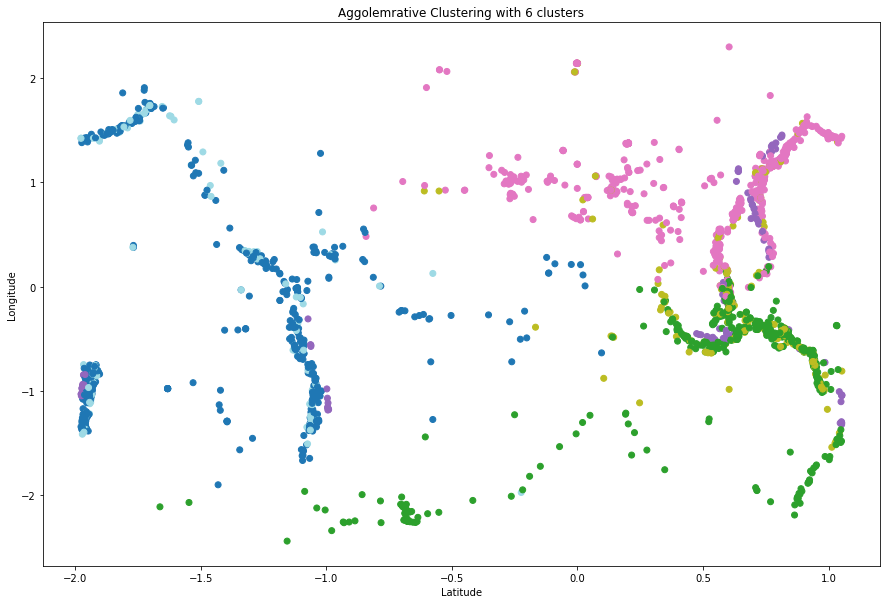

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(df_scaled[:, 2], df_scaled[:, 1], c = cluster_labels, cmap = 'tab20')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title(f'Aggolemrative Clustering with {n_clusters} clusters')
plt.show()

There is not much difference in KMeans and Agglomerative clustering.

I would "draw a line" for the threshold about 25. That line cuts 5-6 times by the connections. So it's the same result as the elbow method gave. I choose 6 clusters.

# DBSCAN

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps = 0.5, min_samples = 5)
dbscan.fit(df_scaled)

DBSCAN()

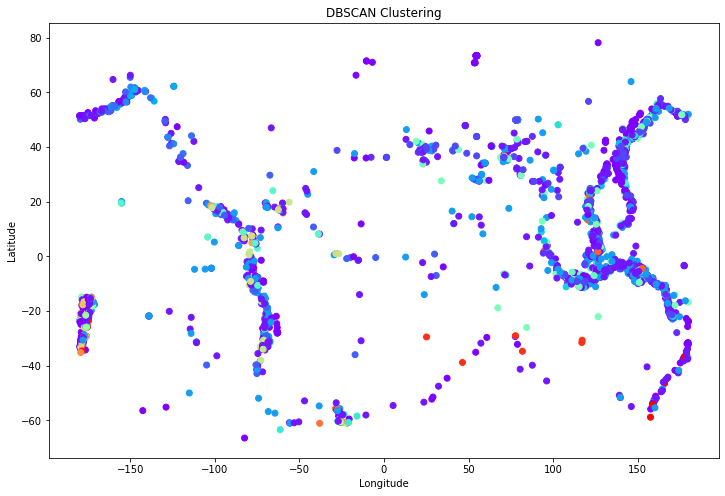

In [ ]:
plt.figure(figsize = (12, 8))
plt.scatter(df['Longitude'], df['Latitude'], c = dbscan.labels_, cmap = 'rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
plt.show()

Let's make some hyperparameter tuning

In [ ]:
epsilon_param_options = np.arange(0.001, 10, 0.01)
min_samples_param_options = np.arange(2, df_scaled.shape[1]+1, 1)
param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

print('Amount of hyperparameters combinations: {}'.format(len(epsilon_param_options) * len(min_samples_param_options)))

Amount of hyperparameters combinations: 3000


In [ ]:
params_dict = {}

for param_set in tqdm(param_grid, total=len(epsilon_param_options) * len(min_samples_param_options)):
  dbscan = DBSCAN(eps=param_set[0], min_samples=param_set[1])

  y_dbscan = dbscan.fit_predict(df_scaled)

  if len(set(y_dbscan) - set([-1])) == 3:a
    params_dict['{}_{}_{}'.format(len(set(y_dbscan) - set([-1])), param_set[0], param_set[1])] = param_set

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
params_dict

{'3_0.8509999999999999_4': (0.8509999999999999, 4),
 '3_0.8609999999999999_4': (0.8609999999999999, 4),
 '3_0.8709999999999999_3': (0.8709999999999999, 3),
 '3_0.9009999999999999_3': (0.9009999999999999, 3),
 '3_0.9109999999999998_3': (0.9109999999999998, 3),
 '3_0.9209999999999998_3': (0.9209999999999998, 3),
 '3_0.9309999999999998_2': (0.9309999999999998, 2),
 '3_0.9409999999999998_2': (0.9409999999999998, 2),
 '3_0.9509999999999998_2': (0.9509999999999998, 2)}

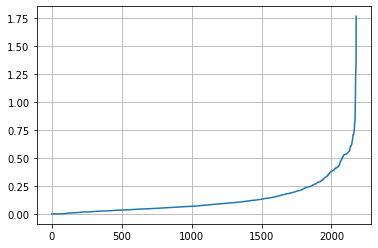

In [ ]:
neighbours = NearestNeighbors(n_neighbors=2)
nbrs = neighbours.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)

Since we have not so much possible parameter, I calculate the Silhouette and Calisnki-Harabasz score for all of them, and choose which gave the best.

In [ ]:
for params_key in params_dict.keys():
  print(params_key)
  dbscan = DBSCAN(eps=params_dict[params_key][0], min_samples=params_dict[params_key][1])
  labels = dbscan.fit_predict(df_scaled)

  silhouette = silhouette_score(df_scaled, labels)
  calinski_harabasz = calinski_harabasz_score(df_scaled, labels)

  print("Silhouette score:", silhouette)
  print("Calinski-Harabasz score:", calinski_harabasz)
  print('-'*30)

3_0.8509999999999999_4
Silhouette score: 0.2979397650256346
Calinski-Harabasz score: 55.38965130842861
------------------------------
3_0.8609999999999999_4
Silhouette score: 0.2979397650256346
Calinski-Harabasz score: 55.38965130842861
------------------------------
3_0.8709999999999999_3
Silhouette score: 0.32178602240445026
Calinski-Harabasz score: 43.34293699780203
------------------------------
3_0.9009999999999999_3
Silhouette score: 0.4313314760372612
Calinski-Harabasz score: 41.15315860097602
------------------------------
3_0.9109999999999998_3
Silhouette score: 0.4313314760372612
Calinski-Harabasz score: 41.15315860097602
------------------------------
3_0.9209999999999998_3
Silhouette score: 0.4313314760372612
Calinski-Harabasz score: 41.15315860097602
------------------------------
3_0.9309999999999998_2
Silhouette score: 0.39449684238715915
Calinski-Harabasz score: 36.247771919221066
------------------------------
3_0.9409999999999998_2
Silhouette score: 0.3944968423871591

Interestingly while the Silhouette score increasing, the Calisnki-Harabasz score is decreasing at the same time.

I choose this parameters:


Parameter: `3_0.9109999999999998_3`

Silhouette score: `0.4313314760372612`

Calinski-Harabasz score: `41.15315860097602`

In [ ]:
dbscan = DBSCAN(eps = params_dict['3_0.9109999999999998_3'][0], min_samples = params_dict['3_0.9109999999999998_3'][1])
dbscan.fit(df_scaled)

DBSCAN(eps=0.9109999999999998, min_samples=3)

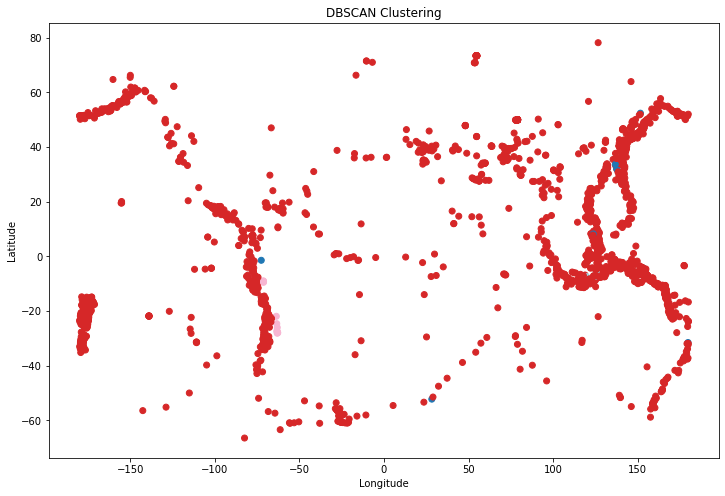

In [ ]:
plt.figure(figsize = (12, 8))
plt.scatter(df['Longitude'], df['Latitude'], c = dbscan.labels_, cmap = 'tab20')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
plt.show()

Well, this plot is a bit different than the others before. A huge datas are predicted to be in one cluster (in the red one).

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
kmeans_labels = kmeans.fit_predict(df_scaled)
dbscan_labels = dbscan.fit_predict(df_scaled)
print("DBSCAN adjusted Rand index: {:.2f}".format(adjusted_rand_score(kmeans_labels, dbscan_labels)))
print("DBSCAN normalized mutual information: {:.2f}".format(normalized_mutual_info_score(kmeans_labels, dbscan_labels)))

agg_labels = agg_clustering.fit_predict(df_scaled)
print("Agglomerative clustering adjusted Rand index: {:.2f}".format(adjusted_rand_score(kmeans_labels, agg_labels)))
print("Agglomerative clustering normalized mutual information: {:.2f}".format(normalized_mutual_info_score(kmeans_labels, agg_labels)))

DBSCAN adjusted Rand index: 0.01
DBSCAN normalized mutual information: 0.04
Agglomerative clustering adjusted Rand index: 0.61
Agglomerative clustering normalized mutual information: 0.63


Based on these scores, the agglomerative clustering performs better.

My final choice of the best clusterization is the KMeans and Agglomerative clustering. They seemed to be the best, however DBSCAN had a very low Rand Index (I assume that something went wrong in my implementation or thinking).